# Dangours Farm Insects CNN Classifier 


## Installing and Loading Required Libraries

In [2]:
!pip install pytorch_lightning
!pip install pytorch
!pip install numpy
!pip install pandas
!pip install matplotlib

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pytorch
Failed to build pytorch


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\abeel\AppData\Local\Temp\pip-install-p_d245j6\pytorch_ee074983be464b74acc44398bc1fa9e8\setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects


In [3]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.


## Preprocessing Data

### Obtaining Classifications

In [4]:
dir0='./farm_insects'
class_names=sorted(os.listdir(dir0)) 
print(class_names)

['Africanized Honey Bees (Killer Bees)', 'Aphids', 'Armyworms', 'Brown Marmorated Stink Bugs', 'Cabbage Loopers', 'Citrus Canker', 'Colorado Potato Beetles', 'Corn Borers', 'Corn Earworms', 'Fall Armyworms', 'Fruit Flies', 'Spider Mites', 'Thrips', 'Tomato Hornworms', 'Western Corn Rootworms']


### Specifying Transformations

In [5]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

### Creating Data Modules

In [6]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, transform=transform, batch_size=32, num_workers=32):
        super().__init__()
        self.root_dir = "./farm_insects"
        self.transform = transform
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.8 * n_data)
        n_test = n_data - n_train

        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_test])

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size)

    def train_dataloader(self):
        return self.train_dataset

    def test_dataloader(self):
        return self.test_dataset


### Creating CNN Model

In [7]:
class ConvolutionalNetwork(LightningModule):
    
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, len(class_names))

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.004)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

## Training Model

In [8]:
if __name__ == '__main__':
    datamodule = DataModule()
    datamodule.setup()
    model = ConvolutionalNetwork()
    trainer = pl.Trainer(max_epochs=30)
    trainer.fit(model, datamodule)
    datamodule.setup(stage='test')
    test_loader = datamodule.test_dataloader()
    trainer.test(dataloaders=test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\abeel\anaconda3\envs\homl3_20240201\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Missing logger folder: c:\Users\abeel\OneDrive - Conestoga College\Conestoga-Term8\PROG74000 - Applications of Artifical Inteligence\Project\lightning_logs

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 168   
1 | conv2 | Conv2d | 880   
2 | fc1   | Linear | 5.6 M 
3 | fc2   | Linear | 10.2 K
4 | fc3   | Linear | 1.7 K 
5 | fc4   | Linear | 315   
---------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.448    Total estimated model params size (MB)
c:\Users\abeel\anaconda3\envs\homl3_20240201\lib\site-packages\pytorch_lightning\trainer\connectors\d

Training: |          | 0/? [00:00<?, ?it/s]

Palette images with Transparency expressed in bytes should be converted to RGBA images
`Trainer.fit` stopped: `max_epochs=30` reached.
c:\Users\abeel\anaconda3\envs\homl3_20240201\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at c:\Users\abeel\OneDrive - Conestoga College\Conestoga-Term8\PROG74000 - Applications of Artifical Inteligence\Project\lightning_logs\version_0\checkpoints\epoch=29-step=1200.ckpt
Loaded model weights from the checkpoint at c:\Users\abeel\OneDrive - Conestoga College\Conestoga-Term8\PROG74000 - Applications of Artifical Inteligence\Project\lightning_logs\version_0\checkpoints\epoch=29-step=1200.ckpt
c:\Users\abeel\a

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5126582384109497     │
│         test_loss         │     1.591124176979065     │
└───────────────────────────┴───────────────────────────┘

## Evaluating Model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


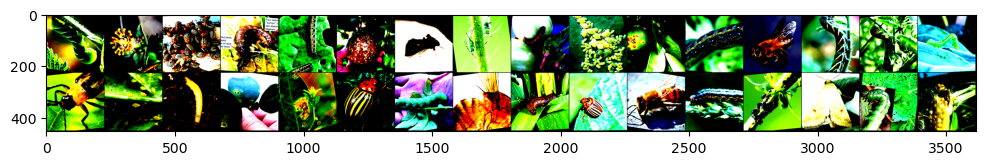

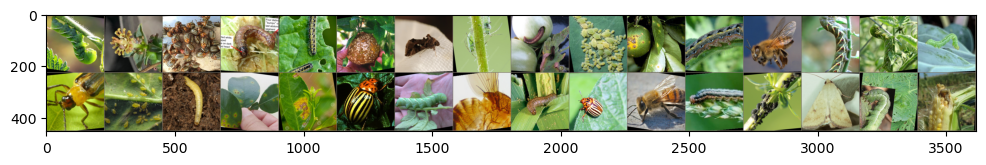

In [9]:
for images, labels in datamodule.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [10]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.test_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

Palette images with Transparency expressed in bytes should be converted to RGBA images


                                      precision    recall  f1-score   support

Africanized Honey Bees (Killer Bees)     0.6000    0.6000    0.6000        15
                              Aphids     0.5385    0.4667    0.5000        15
                           Armyworms     0.4545    0.2083    0.2857        24
         Brown Marmorated Stink Bugs     0.6667    0.5455    0.6000        22
                     Cabbage Loopers     0.7778    0.7000    0.7368        20
                       Citrus Canker     0.5714    0.3810    0.4571        21
             Colorado Potato Beetles     0.5882    0.4348    0.5000        23
                         Corn Borers     0.5263    0.4348    0.4762        23
                       Corn Earworms     0.4688    0.6250    0.5357        24
                      Fall Armyworms     0.3409    0.6000    0.4348        25
                         Fruit Flies     0.4634    0.8261    0.5938        23
                        Spider Mites     0.5556    0.6250    0.

## Saving the Model

In [11]:
torch.save(model.state_dict(), 'scary_bugs_classification.pth') # Saves to the root directory


# Uncomment the line below to save the model to the application 
# torch.save(model.state_dict(), './app/backend/scary_bugs_classification.pth') 


## Prediction Functions  

In [14]:
model = ConvolutionalNetwork()
model.load_state_dict(torch.load('scary_bugs_classification.pth'))
model.eval()

# Function to predict the class of the bug
def predict_image(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0) 

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted[0].item()]
    
    return predicted_class

# Predict the class of the bug
predict_image('./farm_insects/Aphids/Image_1.jpeg')




'Spider Mites'